In [ ]:
import cvxpy as cp
import numpy as np
from scipy.sparse import csr_array
import scipy as sp
import matplotlib.pyplot as plt
from collections import Counter
from .common import SiteBasis

In [ ]:
def basis_commutator(o1, o2):
    commutation_table = [
        [(0, ''),(0, ''),(0, ''),(0, '')],
        [(0, ''),(0, ''),(2j, 'Z'),(-2j, 'Y')],
        [(0, ''),(-2j, 'Z'),(0, ''),(2j, 'X')],
        [(0, ''),(2j, 'Y'),(-2j, 'X'),(0, '')],
    ]
    return commutation_table['IXYZ'.find(o1)]['IXYZ'.find(o2)]

def basis_anticommutator(o1, o2):
    anticommutation_table = [
        [(2, 'I'),(2, 'X'),(2, 'Y'),(2, 'Z')],
        [(2, 'X'),(2, 'I'),(0, ''),(0, '')],
        [(2, 'Y'),(0, ''),(2, 'I'),(0, '')],
        [(2, 'Z'),(0, ''),(0, ''),(2, 'I')],
    ]
    return anticommutation_table['IXYZ'.find(o1)]['IXYZ'.find(o2)]

def basis_product(o1, o2):
    product_table = [
        [(1, 'I'),(1, 'X'),(1, 'Y'),(1, 'Z')],
        [(1, 'X'),(1, 'I'),(1j, 'Z'),(-1j, 'Y')],
        [(1, 'Y'),(-1j, 'Z'),(1, 'I'),(1j, 'X')],
        [(1, 'Z'),(1j, 'Y'),(-1j, 'X'),(1, 'I')],
    ]
    return product_table['IXYZ'.find(o1)]['IXYZ'.find(o2)]

def anticommutator(word1, word2):
    if len(word1) != len(word2):
        raise ValueError(f'{word1} and {word2} do not have same length')
    if len(word1) == 1:
        return [basis_anticommutator(word1, word2)]
    expression = []
    e_1 = commutator(word1[0],word2[0])
    e_2 = commutator(word1[1:], word2[1:])
    e_3 = anticommutator(word1[0], word2[0])
    e_4 = anticommutator(word1[1:],word2[1:])
    for c1, o1 in e_1:
        for c2, o2 in e_2:
            expression.append((0.5 * c1 * c2, o1 + o2))
    for c1, o1 in e_3:
        for c2, o2 in e_4:
            expression.append((0.5 * c1 * c2, o1 + o2))
    return expression

def commutator(word1: str, word2: str):
    if len(word1) != len(word2):
        raise ValueError(f'{word1} and {word2} do not have same length')
    if len(word1) == 1:
        return [basis_commutator(word1, word2)]
    expression = []
    e_1 = commutator(word1[0],word2[0])
    e_2 = anticommutator(word1[1:], word2[1:])
    e_3 = anticommutator(word1[0], word2[0])
    e_4 = commutator(word1[1:],word2[1:])
    for c1, o1 in e_1:
        for c2, o2 in e_2:
            expression.append((0.5 * c1 * c2, o1 + o2))
    for c1, o1 in e_3:
        for c2, o2 in e_4:
            expression.append((0.5 * c1 * c2, o1 + o2))
    return expression

def product(word1, word2):
    if len(word1) != len(word2):
        raise ValueError(f'{word1} and {word2} do not have same length')
    word = []
    coeff = 1
    for o1, o2 in zip(word1, word2):
        c, op = basis_product(o1, o2)
        word.append(op)
        coeff *= c
    return (coeff, ''.join(word))

<h2>Thermal Transverse Field Ising:</h2>

In [4]:
def schwinger_dyson(hamil: list, word1: str):
    expression = []
    for coeff, w in hamil:
        terms = commutator(w, word1)
        for c, op in terms:
            if len(op) != len(word1):
                continue
            if not np.isclose(np.abs(coeff * c), 0):
                expression.append((op, coeff * c))
    return expression

def normalization(basis, L, B):
    return [B[basis.rank('I'*L)] == 1]

def beta_independent_constraints(basis, B, L, hamil):
    constraints = []
    constraints.extend(normalization(basis, L, B))
    row_ind, col_ind, data = [], [], []
    numc = 0
    n = basis.size()
    def add_terms(terms):
        nonlocal numc
        new_row = 0
        cnt = 0
        for term in terms:
            cnt += 1
            new_row = 1
            col_ind.append(basis.rank(term[0]))
            data.append(term[1])
            row_ind.append(numc)
        numc += new_row
    for word in basis._ops:
        add_terms(schwinger_dyson(hamil, word))
    if len(col_ind) > 0:
        P = csr_array((data, (row_ind, col_ind)), (numc, n))
        constraints.append(P @ B == 0)
    return constraints

def test_kms(basis, H, hamil, beta, k):
    ops = basis._ops
    n = len(ops)
    constraints = []
    def get_A_term(i, j):
        coeff, word = product(ops[i], ops[j])
        return coeff * H[basis.rank(word)]
    A = cp.bmat([[get_A_term(i, j) for j in range(n)] for i in range(n)])
    def get_C_term(i, j):
        expression = 0
        termsd = Counter()
        for coeff, w in hamil:
            terms = commutator(w, ops[j])
            for c, op in terms:
                if len(op) != len(w):
                    continue
                c2, op2 = product(ops[i], op)
                termsd[op2] += coeff * c * c2
        for op, coeff in termsd.items():
            if np.isclose(np.abs(coeff),0):
                continue
            expression = expression + coeff * H[basis.rank(op)]
        return expression
    C = cp.bmat([[get_C_term(i, j) for j in range(n)] for i in range(n)])
    T = 2**(-k) * beta * C
    B = cp.conj(A)
    Zs = [B] + [cp.Variable((n,n),f'Z_{i}',hermitian=True) for i in range(1, k + 1)]
    for i in range(k):
        constraints.append(cp.bmat([[Zs[i], Zs[i+1]],
                                    [Zs[i+1], A]]) >> 0)
    al, be, ga, de = -1, 5, 2, 4
    b = (be*de - ga) / (be - al)
    a = de - b
    constraints.append(cp.bmat([[Zs[k] + al*A + a*T, np.sqrt(a*b) * T],
                                [np.sqrt(a*b) * T, Zs[k] + be*A + b*T]]) >> 0)
    # # large x
    # v = 0.3
    # al, be, ga, de = -1.2, 15, 6.3, 10
    # b = (be*de - ga) / (be - al)
    # a = de - b
    # constraints.append(cp.bmat([[Zs[k] + al*A + a*(T+v*A), np.sqrt(a*b) * (T+v*A)],
    #                             [np.sqrt(a*b) * (T+v*A), Zs[k] + be*A + b*(T+v*A)]]) >> 0)
    # # small x
    # u, v = -0.3, 0.13
    # al, be, ga, de = -1-u, 5+u, 2+4*u, 4
    # b = (be*de - ga) / (be - al)
    # a = de - b
    # constraints.append(cp.bmat([[Zs[k] + al*A + a*(T+v*A), np.sqrt(a*b) * (T+v*A)],
    #                             [np.sqrt(a*b) * (T+v*A), Zs[k] + be*A + b*(T+v*A)]]) >> 0)
    return constraints

In [5]:
def construct_hamil(L, h):
    hamil = []
    for i in range(L):
        t1 = None
        if i<L-1:
            t1 = 'I'*i + 'XX' + 'I'*(L-i-2)
        else:
            t1 = 'X' + 'I'*(L-2) + 'X'
        t2 = 'I'*i+'Z'+'I'*(L-i-1)
        hamil.extend([(-1, t1), (-h, t2)])
    if L == 2:
        hamil = [(-h, 'IZ'), (-h, 'ZI'), (-1, 'XX')]
    return hamil

def construct_problem(L, h, k):
    basis = SiteBasis(L)
    B = cp.Variable(basis.size())
    hamil = construct_hamil(L, h)
    beta = cp.Parameter(nonneg = True)
    constraints = beta_independent_constraints(basis, B, L, hamil)
    constraints.extend(test_kms(basis, B, hamil, beta, k))
    energy = -1 * L * B[basis.rank('XX'+'I'*(L-2))] - h * L * B[basis.rank('Z'+'I'*(L-1))]
    if L == 2:
        energy = -1 * B[basis.rank('XX')] - h * 2 * B[basis.rank('Z'+'I'*(L-1))]
    minprob = cp.Problem(cp.Minimize(energy), constraints)
    maxprob = cp.Problem(cp.Maximize(energy), constraints)
    return beta, minprob, maxprob

def solve_energy(betas, beta, minprob, maxprob):
    mins,maxs = np.zeros_like(betas), np.zeros_like(betas)
    for i, val in enumerate(betas):
        beta.value = val
        print(f'Solving for T={1/val}, i={i}:')
        E_min = minprob.solve(accept_unknown=True)
        E_max = maxprob.solve(accept_unknown=True)
        print(f'\tE_min = {E_min}')
        print(f'\tE_max = {E_max}')
        mins[i], maxs[i] = E_min, E_max
    return mins, maxs

In [6]:
L, h, k = 2, 1, 2
beta, minprob, maxprob = construct_problem(L, h, k)

In [7]:
betas = 1/np.linspace(0.01, 4, num = 5)
mins, maxs = solve_energy(betas, beta, minprob, maxprob)

Solving for T=0.01, i=0:


/home/mainak/mtp/my-work/.venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:164: UserWarning: Constraint #5 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


	E_min = -2.236067971074589
	E_max = -2.2360679707694366
Solving for T=1.0075, i=1:
	E_min = -1.8356385592872506
	E_max = -1.8245360202488436
Solving for T=2.005, i=2:
	E_min = -1.266691063441074
	E_max = -1.264041718306268
Solving for T=3.0025, i=3:
	E_min = -0.9221160549985705
	E_max = -0.9213936140194958
Solving for T=4.0, i=4:
	E_min = -0.7158660132517951
	E_max = -0.7156077152748049


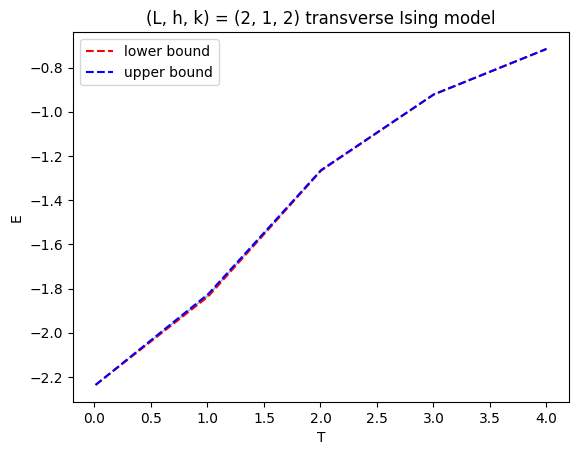

In [8]:
plt.fill_between(1/betas, mins, maxs, alpha = 0.5)
plt.plot(1/betas, mins,c ='red',linestyle='--',label='lower bound')
plt.plot(1/betas, maxs,c ='blue',linestyle='--',label='upper bound')
plt.xlabel('T')
plt.ylabel('E')
plt.title(f'(L, h, k) = ({L}, {h}, {k}) transverse Ising model')
plt.legend()
plt.show()